In [1]:
import numpy as np
from ase.build import molecule
from ase.visualize import view
import sys
sys.path.insert(0,"/home/valeria/Documents/DFTPY/PseudoP/vg/pyscf")
from pyscf.pbc.tools.pyscf_ase import atoms_from_ase
from pyscf import gto,dft
import matplotlib.pyplot as plt
from pyscf import scf

import qmlearn as qml
from ase.vibrations import Infrared
from ase.io.trajectory import Trajectory

from qmlearn.api.api4ase import QMLCalculator
from qmlearn.drivers.mol import QMMol
from qmlearn.preprocessing import get_train_atoms

from sklearn.model_selection import train_test_split 
from sklearn import metrics

# pca
import pickle

In [2]:
with open('/home/valeria/Documents/DFTPY/project_2/DATA/d_vext_pca', 'rb') as f:
    D_vext = pickle.load(f)
with open('/home/valeria/Documents/DFTPY/project_2/DATA/g_gamma_pca', 'rb') as f:
    D_gamma = pickle.load(f)

In [ ]:
D_vext = []
D_gamma =[]
for i in range(len(d_vext)):
    for j in range(len(d_vext[1])):
        D_vext.append(d_vext[i][j])
        D_gamma.append(d_gamma[i][j])

In [15]:
from sklearn.kernel_ridge import KernelRidge as modelKR
from sklearn.linear_model import Ridge as modelR
# from sklearn.linear_model import Lasso as modelL

X_def = np.asarray(D_vext)
y_def = np.asarray(D_gamma)

# flatten the matrices to create input features and target variable
X = X_def.reshape(-1, len(X_def[1])*len(X_def[1]))
y = y_def.reshape(-1, len(X_def[1])*len(X_def[1]))

# split the data into training and testing sets [:100,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train a Kernel Ridge regression model with a linear kernel and regularization parameter alpha=0.1
kr = modelKR(alpha=0.01)
r = modelR(alpha=0.01)
# L =modelL(alpha=0.0)

kr.fit(X_train, y_train)
r.fit(X_train, y_train)
# L.fit(X_train, y_train)
# evaluate the model on the test set
scorekr = kr.score(X_test, y_test)
scorer = r.score(X_test, y_test)
# scoreL = L.score(X_test, y_test)

print(f"R^2 score on test set with Kernel Ridge model: {scorekr:.3f}")
print(f"R^2 score on test set with Ridge model: {scorer:.3f}")
# print(f"R^2 score on test set with Lasso model: {scoreL:.3f}")

R^2 score on test set with Kernel Ridge model: 0.884
R^2 score on test set with Ridge model: 0.909


In [5]:
atoms = molecule('H2O')
basis = 'sto-3g'
xc = 'lda,vwn_rpa'
charge = 0
mol = gto.M(atom = atoms_from_ase(atoms), spin=0, basis=basis, charge = charge, parse_arg = False)

In [6]:
from pyscf.grad import rhf
from pyscf import scf
mf = scf.RKS(mol)
mf.run()
gammaorig = mf.make_rdm1()

converged SCF energy = -74.7349378400072


In [7]:
# Create the gamma filter
def gaussian_matrix(sigma, mu):
    x, y = np.meshgrid(np.linspace(-1,1, len(gammaorig)), np.linspace(-1,1, len(gammaorig)))
    d = np.sqrt(x**2+y**2)
#     sigma, mu = 1.0, 0.0
    return np.exp(-((d-mu)**2 / (2.0 * sigma**2)))

In [8]:
from scipy import signal
from scipy.ndimage import gaussian_filter

o=mf.mo_occ
c=mf.mo_coeff
gammaorig=np.einsum('i,mi,ni->mn',o,c,c)
kin=mol.intor_symmetric('int1e_kin')
potorig=mol.intor_symmetric('int1e_nuc')
def random_v(shape,eps):
    bla=np.random.random(shape)
    bla=(bla+bla.T)/2.0
    return bla*eps
shape = np.shape(potorig)
randpot1=random_v(shape,0.01)
randpot2 = randpot1 - np.trace(randpot1)* 1/len(gammaorig)
# g_filter = gaussian_matrix(1,0)
randpot = gaussian_filter(randpot2,1)
mf = scf.RKS(mol)
bla = mf.get_hcore
def my_get_hcore(mol):
    hcore=bla(mol)
    hcore+=randpot 
    return hcore
mf.get_hcore = my_get_hcore
mf.run()
newgamma=mf.make_rdm1()

dgamma = gammaorig-newgamma

Overwritten attributes  get_hcore  of <class 'pyscf.dft.rks.RKS'>


converged SCF energy = -74.7300659993954


In [9]:
kr_gamma = kr.predict(randpot.reshape(-1,7*7))
r_gamma = r.predict(randpot.reshape(-1,7*7))

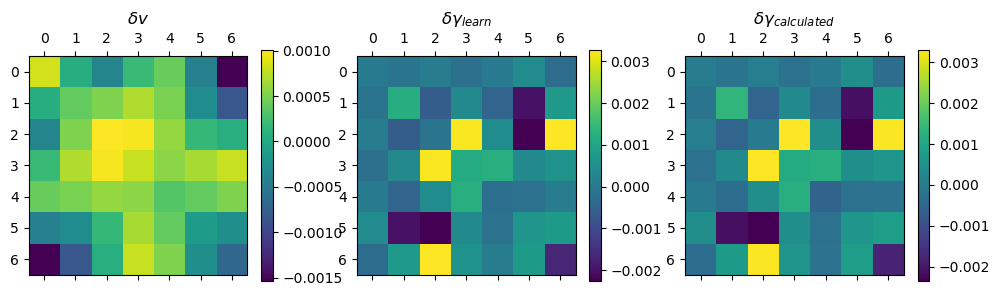

In [13]:
# Ridge R^2=0.947
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].matshow(randpot)
im1 = axs[1].matshow(kr_gamma.reshape(7,7))
im2 = axs[2].matshow(dgamma)
axs[0].set_title('$\u03B4 v$')
axs[1].set_title('$\u03B4 \gamma_{learn}$')
axs[2].set_title('$\u03B4 \gamma_{calculated}$')
# axs[0].matshow(randpot)
# axs[1].matshow(gamma.reshape(58,58))
# axs[2].matshow(dgamma)
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])

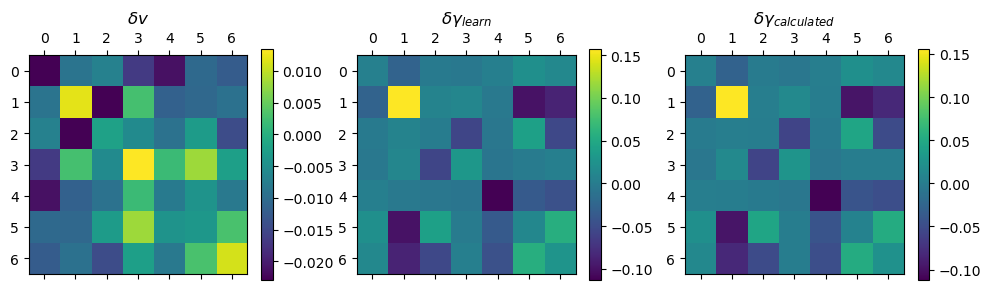

In [10]:
# Ridge R^2=0.947
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].matshow(randpot)
im1 = axs[1].matshow(dgamma)
im2 = axs[2].matshow(pgamma.reshape(7,7))
axs[0].set_title('$\u03B4 v$')
axs[1].set_title('$\u03B4 \gamma_{learn}$')
axs[2].set_title('$\u03B4 \gamma_{calculated}$')
# axs[0].matshow(randpot)
# axs[1].matshow(gamma.reshape(58,58))
# axs[2].matshow(dgamma)
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])

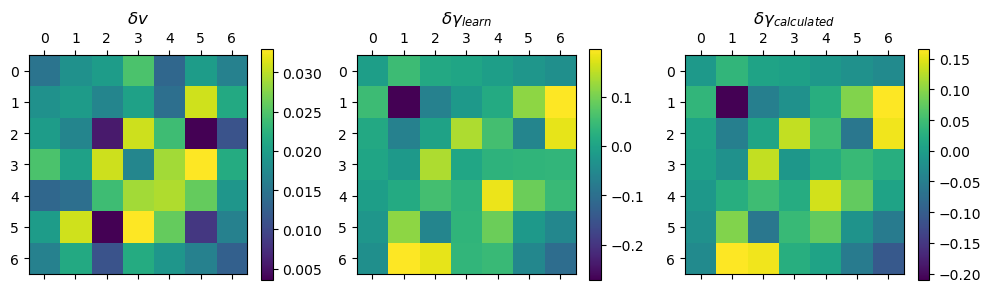

In [32]:
# KernelRidge R^2=0.89
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].matshow(randpot)
im1 = axs[1].matshow(pgamma.reshape(7,7))
im2 = axs[2].matshow(dgamma)
axs[0].set_title('$\u03B4 v$')
axs[1].set_title('$\u03B4 \gamma_{learn}$')
axs[2].set_title('$\u03B4 \gamma_{calculated}$')
# axs[0].matshow(randpot)
# axs[1].matshow(gamma.reshape(58,58))
# axs[2].matshow(dgamma)
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])

In [14]:
def rmsd(A_list, B_list):
    n = len(A_list)
    diff_sq_sum = 0
    for i in range(n):
        diff = A_list[i] - B_list[i]
        diff_sq_sum += (diff**2).sum()
    return np.sqrt(diff_sq_sum / (n * A_list[0].size))

In [15]:
v = np.asarray(d_vext)
g = np.asarray(d_gamma)

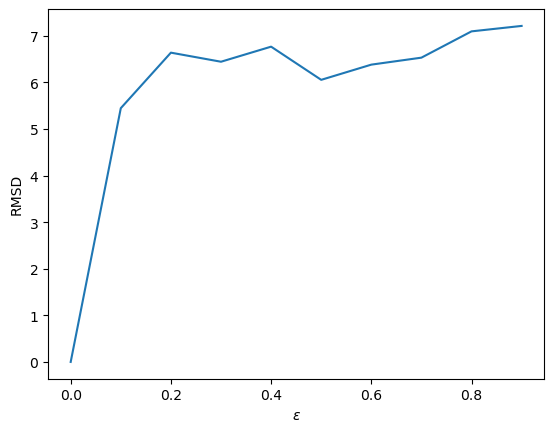

In [19]:
RMSD = []
for i in np.arange(0,len(v)):
        RMSD.append(rmsd(v[i],g[i]))
y = np.asarray(RMSD)
x = np.arange(0,1,0.1)
plt.xlabel('$\u03B5$')
plt.ylabel('RMSD')
plt.plot(x,y)